In [1]:
import numpy as np
import pandas as pd
import os
import math
from operator import truediv
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)


windowSize = 25
batch_size = 64

In [4]:
def padding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createPatch(X, y, windowSize=windowSize):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padding(X, margin=margin)

    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1


    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1


    patchesData = patchesData.transpose((0, 3, 1, 2))

    return patchesData, patchesLabels


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


def splitTrainTestSet(X, y, randomState=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
from scipy.io import loadmat

X=loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU.mat')['paviaU']
y= loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU_gt.mat')['paviaU_gt']


X=applyPCA(X)

X,y=createPatch(X,y)

print(X.shape)
print(y.shape)


(42776, 15, 25, 25)
(42776,)


# Triplet Loss için Ön işleme

In [ ]:
X_df = pd.DataFrame(X.reshape(X.shape[0], -1))
df = pd.DataFrame(X.reshape(X.shape[0], -1))
df['class'] = y.ravel()

y_df= df['class']
X_train_df,X_val_df,X_test_df,y_train_df,y_val_df,y_test_df=splitTrainTestSet(X_df,y_df)

print(X_train_df.shape)
print(X_val_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_val_df.shape)
print(y_test_df.shape)


### görsel ön işlemi

columns = ['archor_img','postive_img','close_positive_img','negative_img','label']
df_train_for_triplet=pd.DataFrame(columns=columns)
df_test_for_triplet=pd.DataFrame(columns=columns)
df_val_for_triplet=pd.DataFrame(columns=columns)

val_df=pd.concat([X_val_df,y_val_df],axis=1)
train_df=pd.concat([X_train_df, y_train_df], axis=1)
test_df=pd.concat([X_test_df,y_test_df],axis=1)

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

train_df_reset_index= train_df.reset_index()
test_df_reset_index = test_df.reset_index()
val_df_reset_index = val_df.reset_index()



(12832, 9375)
(17966, 9375)
(11978, 9375)
(12832,)
(17966,)
(11978,)
(12832, 9376)
(11978, 9376)
(17966, 9376)


In [ ]:
for index, row in train_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1;
       while(index_2 <train_df_reset_index.shape[0]-1 and train_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <train_df_reset_index.shape[0]-1):
            positive = train_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,train_df_reset_index.shape[0])
            while(train_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,train_df_reset_index.shape[0])
            negative = train_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_train_for_triplet=df_train_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_train_for_triplet

,archor_img,postive_img,close_positive_img,negative_img,label
0,18376.0,18376.0,13189.0,35638.0,5.0
1,25451.0,25451.0,27378.0,25032.0,7.0
2,3195.0,3195.0,39872.0,19585.0,1.0
3,39872.0,39872.0,40954.0,22601.0,1.0
4,8115.0,8115.0,794.0,17363.0,0.0
...,...,...,...,...,...
12817,1685.0,1685.0,41090.0,808.0,1.0
12818,41090.0,41090.0,38158.0,36382.0,1.0
12819,21962.0,21962.0,11284.0,32334.0,0.0
12820,37194.0,37194.0,16850.0,38718.0,3.0


In [ ]:
df_train_for_triplet.to_csv('pavia_triplet_train.csv')

In [ ]:
for index, row in test_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1;
       while(index_2 < test_df_reset_index.shape[0]-1 and test_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <test_df_reset_index.shape[0]-1):
            positive = test_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,test_df_reset_index.shape[0])
            while(test_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,test_df_reset_index.shape[0])
            negative = test_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_test_for_triplet=df_test_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_test_for_triplet.to_csv('pavia_triplet_test.csv')

In [ ]:
for index, row in val_df_reset_index.iterrows():
       label= row['class']
       archor_img = row['index']
       index_2 = index+1;

       while(index_2 < val_df_reset_index.shape[0]-1 and val_df_reset_index.iloc[index_2]['class'] != label ):
              index_2 = index_2 + 1

       if(index_2 <val_df_reset_index.shape[0]-1):
            positive = val_df_reset_index.iloc[index_2]['index']
            c=np.random.randint(1,val_df_reset_index.shape[0])
            while(val_df_reset_index.iloc[c]['class']==label):
                c=np.random.randint(1,val_df_reset_index.shape[0])
            negative = val_df_reset_index.iloc[c]['index']
            new_row_dict = {'archor_img': archor_img, 'postive_img': archor_img, 'close_positive_img':positive, 'negative_img': negative, 'label': label}
            df_val_for_triplet=df_val_for_triplet._append(new_row_dict, ignore_index=True)

In [ ]:
df_val_for_triplet.to_csv('pavia_triplet_val.csv')

# Verilerin alınması

In [6]:
df_train_for_triplet = pd.read_csv('pavia_triplet_train.csv',index_col=0)
df_test_for_triplet = pd.read_csv('pavia_triplet_test.csv',index_col=0)
df_val_for_triplet = pd.read_csv('pavia_triplet_val.csv',index_col=0)

indices_train = df_train_for_triplet.iloc[:, 1].astype(int).values
indices_test = df_test_for_triplet.iloc[:,1].astype(int).values
indices_val = df_val_for_triplet.iloc[:,1].astype(int).values

X_Train = X[indices_train]
X_Val = X[indices_val]
X_Test = X[indices_test]
y_Train = y[indices_train]
y_Val = y[indices_val]
y_Test = y[indices_test]

In [7]:
class HSIDataset():

    def __init__(self, datafr,X_np,train=True):
        self.data = datafr
        self.X_np = X_np


        self.anchorimages = datafr.iloc[:, 0].values
        self.anchorlabels = datafr.iloc[:, 4].values
        self.positiveimages = datafr.iloc[:, 2].values
        self.negativeimages = datafr.iloc[:, 3].values
        self.index = datafr.index.values

    def __len__(self):
        return len(self.anchorimages)

    def __getitem__(self, item):


        anchor_image_index = self.anchorimages[item]
        anchor_image_index=int(anchor_image_index)
        anchor_img = self.X_np[anchor_image_index]


        anchor_label = self.anchorlabels[item]



        positive_image_index = self.positiveimages[item]
        positive_image_index=int(positive_image_index)
        positive_img =self.X_np[positive_image_index]



        negative_image_index = self.negativeimages[item]
        negative_image_index=int(negative_image_index)
        negative_img = self.X_np[negative_image_index]

        anchor_img_tensor = torch.tensor(anchor_img)
        positive_img_tensor = torch.tensor(positive_img)
        negative_img_tensor = torch.tensor(negative_img)
        anchor_label_tensor = torch.tensor(anchor_label)


        anchor_img_tensor=anchor_img_tensor.float()
        positive_img_tensor=positive_img_tensor.float()
        negative_img_tensor=negative_img_tensor.float()
        anchor_label_tensor=anchor_label_tensor.float()

        return anchor_img_tensor, positive_img_tensor, negative_img_tensor, anchor_label_tensor





def get_train_dataset():
    train_dataset = HSIDataset(df_train_for_triplet,X)
    return train_dataset

def get_test_dataset():
    test_dataset = HSIDataset(df_test_for_triplet,X)
    return test_dataset

def get_val_dataset():
    val_dataset = HSIDataset(df_val_for_triplet,X)
    return val_dataset



from torch.utils.data import DataLoader
train_dataset=get_train_dataset()
train_dl = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

val_dataset = get_val_dataset()

val_dl = DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)

test_dataset = get_test_dataset()

test_dl = DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True)



In [8]:
class CNNetwork(nn.Module):
    def __init__(self):
        super(CNNetwork, self).__init__()

        self.conv1 = nn.Conv2d(15, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc4 = nn.Linear(128 * 3 * 3, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc5 = nn.Linear(512, 128)


    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)


        return x



class ClassificationNN(nn.Module):
    def __init__(self):
        super(ClassificationNN, self).__init__()
        self.fc8 = nn.Linear(128,256)
        self.relu1=nn.ReLU(inplace=True)
        self.fc9=nn.Linear(256,512)
        self.relu2=nn.ReLU(inplace=True)
        self.fc10=nn.Linear(512,128)
        self.relu3=nn.ReLU(inplace=True)
        self.fc11=nn.Linear(128,64)
        self.relu4=nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(64, 32)
        self.relu = nn.ReLU(inplace=True)
        self.fc7 = nn.Linear(32, 9)

    def forward(self, x):

        x = self.fc8(x)
        x=self.relu1(x)
        x = self.fc9(x)
        x=self.relu2(x)
        x = self.fc10(x)
        x=self.relu3(x)
        x = self.fc11(x)
        x=self.relu4(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.fc7(x)


        return x


a = nn.TripletMarginLoss()




In [9]:
def evaluate(model, val_dl, loss_fn, device):
    model.eval()
    with torch.no_grad():
        running_loss = []
        running_acc = []


        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(val_dl, desc="Evaluating", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            anchor_label = anchor_label.to(device)

            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)


            triplet_loss = loss_fn(anchor_output, positive_output, negative_output)


            loss = triplet_loss

            running_loss.append(loss.item())



        avg_loss = sum(running_loss) / len(running_loss)


    return avg_loss


def train(model, train_dl, val_dl, loss_fn, optimizer, device):
    # train_acc = []
    # val_acc = []

    train_loss = []
    val_loss = []

    model.train()
    best_val_acc = 0.0
    for epoch in tqdm(range(20), desc="Epochs"):
        running_loss = []
        # running_acc = []

        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_dl, desc="Training", leave=False)):
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            anchor_label = anchor_label.to(device)

            anchor_output = model(anchor_img)
            positive_output = model(positive_img)
            negative_output = model(negative_img)


            triplet_loss = loss_fn(anchor_output, positive_output, negative_output)


            running_loss.append(triplet_loss.item())

            optimizer.zero_grad()
            triplet_loss.backward()
            optimizer.step()


        avg_loss = sum(running_loss) / len(running_loss)



        train_loss.append(avg_loss)



        eval_loss = evaluate(model, val_dl, loss_fn, device)


        val_loss.append(eval_loss)


        print(f"Epoch {epoch+1}/{20} - Training loss: {avg_loss:.4f}, Validation loss: {eval_loss:.4f}")




    return train_loss, val_loss

In [10]:
device = torch.device("cuda")
model = CNNetwork().to(device)
Optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = a

In [11]:
from tqdm import tqdm

In [12]:
train_loss, val_los = train(model, train_dl, val_dl, loss_fn, Optimizer, device)

Training:  98%|█████████▊| 197/201 [00:04<00:00, 110.83it/s]
                                                            
Epochs:   5%|▌         | 1/20 [00:06<02:01,  6.37s/it]

Epoch 1/20 - Training loss: 0.0981, Validation loss: 0.1015



Training: 100%|██████████| 201/201 [00:02<00:00, 103.71it/s]
                                                            
Epochs:  10%|█         | 2/20 [00:10<01:32,  5.13s/it]

Epoch 2/20 - Training loss: 0.0370, Validation loss: 0.0232



Training:  97%|█████████▋| 194/201 [00:01<00:00, 111.68it/s]
                                                            
Epochs:  15%|█▌        | 3/20 [00:14<01:19,  4.66s/it]

Epoch 3/20 - Training loss: 0.0183, Validation loss: 0.0329



Training:  96%|█████████▌| 193/201 [00:01<00:00, 106.97it/s]
                                                            
Epochs:  20%|██        | 4/20 [00:18<01:11,  4.45s/it]

Epoch 4/20 - Training loss: 0.0205, Validation loss: 0.0363



Training:  99%|█████████▊| 198/201 [00:02<00:00, 104.98it/s]
                                                            
Epochs:  25%|██▌       | 5/20 [00:23<01:05,  4.37s/it]

Epoch 5/20 - Training loss: 0.0169, Validation loss: 0.0110



Training:  96%|█████████▌| 193/201 [00:01<00:00, 107.83it/s]
                                                            
Epochs:  30%|███       | 6/20 [00:27<00:59,  4.27s/it]

Epoch 6/20 - Training loss: 0.0068, Validation loss: 0.0351



Training:  95%|█████████▌| 191/201 [00:01<00:00, 109.40it/s]
                                                            
Epochs:  35%|███▌      | 7/20 [00:31<00:54,  4.22s/it]

Epoch 7/20 - Training loss: 0.0434, Validation loss: 0.0367



Training:  99%|█████████▊| 198/201 [00:02<00:00, 104.34it/s]
                                                            
Epochs:  40%|████      | 8/20 [00:35<00:51,  4.26s/it]

Epoch 8/20 - Training loss: 0.0261, Validation loss: 0.0176



Training:  95%|█████████▌| 191/201 [00:01<00:00, 105.49it/s]
                                                            
Epochs:  45%|████▌     | 9/20 [00:39<00:46,  4.23s/it]

Epoch 9/20 - Training loss: 0.0101, Validation loss: 0.0161



Training:  95%|█████████▌| 191/201 [00:01<00:00, 104.75it/s]
                                                            
Epochs:  50%|█████     | 10/20 [00:43<00:42,  4.20s/it]

Epoch 10/20 - Training loss: 0.0090, Validation loss: 0.0089



Training: 100%|█████████▉| 200/201 [00:02<00:00, 105.79it/s]
                                                            
Epochs:  55%|█████▌    | 11/20 [00:48<00:38,  4.25s/it]

Epoch 11/20 - Training loss: 0.0054, Validation loss: 0.0139



Training:  99%|█████████▊| 198/201 [00:01<00:00, 112.01it/s]
                                                            
Epochs:  60%|██████    | 12/20 [00:52<00:33,  4.20s/it]

Epoch 12/20 - Training loss: 0.0202, Validation loss: 0.0316



Training: 100%|█████████▉| 200/201 [00:01<00:00, 109.96it/s]
                                                            
Epochs:  65%|██████▌   | 13/20 [00:56<00:29,  4.19s/it]

Epoch 13/20 - Training loss: 0.0118, Validation loss: 0.0160



Training:  99%|█████████▉| 199/201 [00:01<00:00, 107.67it/s]
                                                            
Epochs:  70%|███████   | 14/20 [01:00<00:25,  4.19s/it]

Epoch 14/20 - Training loss: 0.0026, Validation loss: 0.0105



Training:  99%|█████████▉| 199/201 [00:02<00:00, 108.99it/s]
                                                            
Epochs:  75%|███████▌  | 15/20 [01:04<00:20,  4.19s/it]

Epoch 15/20 - Training loss: 0.0052, Validation loss: 0.0230



Training:  98%|█████████▊| 196/201 [00:01<00:00, 110.56it/s]
                                                            
Epochs:  80%|████████  | 16/20 [01:09<00:16,  4.16s/it]

Epoch 16/20 - Training loss: 0.0090, Validation loss: 0.0318



Training:  96%|█████████▌| 192/201 [00:01<00:00, 107.64it/s]
                                                            
Epochs:  85%|████████▌ | 17/20 [01:13<00:12,  4.19s/it]

Epoch 17/20 - Training loss: 0.0055, Validation loss: 0.0268



Training:  95%|█████████▌| 191/201 [00:01<00:00, 107.97it/s]
                                                            
Epochs:  90%|█████████ | 18/20 [01:17<00:08,  4.17s/it]

Epoch 18/20 - Training loss: 0.0111, Validation loss: 0.0156



Training:  95%|█████████▍| 190/201 [00:01<00:00, 103.36it/s]
                                                            
Epochs:  95%|█████████▌| 19/20 [01:21<00:04,  4.16s/it]

Epoch 19/20 - Training loss: 0.0230, Validation loss: 0.0642



Training:  94%|█████████▍| 189/201 [00:01<00:00, 107.47it/s]
                                                            
Epochs: 100%|██████████| 20/20 [01:25<00:00,  4.29s/it]

Epoch 20/20 - Training loss: 0.0207, Validation loss: 0.0332


In [13]:
torch.save(model.state_dict(), "pavia_triplet_model.pth")

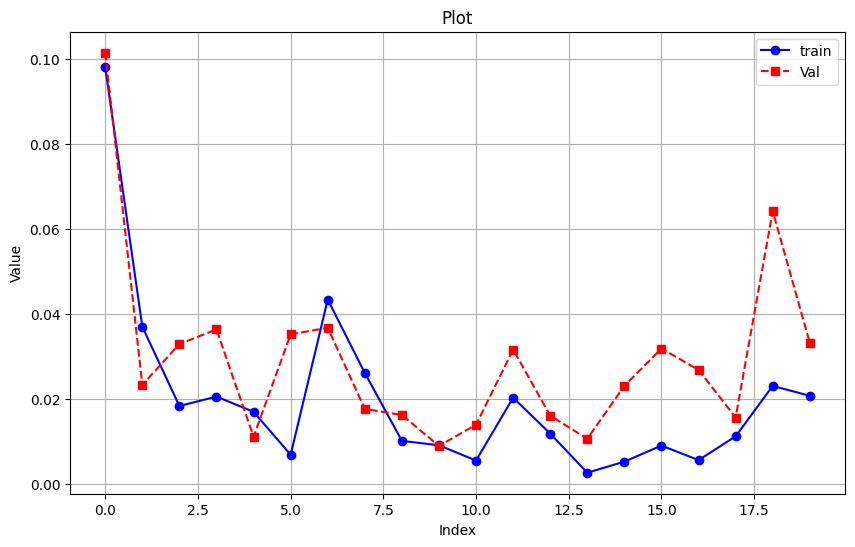

In [14]:
indices =list(range(len(train_loss)))

plt.figure(figsize=(10, 6))
plt.plot(indices, train_loss, marker='o', linestyle='-', color='b', label='train')
plt.plot(indices, val_los, marker='s', linestyle='--', color='r', label='Val')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot')
plt.legend()
plt.grid(True)
plt.show()

# Sınıflandırma

In [15]:
class FeatureDataset():
    def __init__(self, feature, feature_labels):
        self.data = feature
        self.labels = feature_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for anchor_img, _, _, anchor_label in val_dl:
        anchor_img = anchor_img.to(device)
        features = model(anchor_img)
        all_features.append(features)
        all_labels.append(anchor_label)



all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)


dataset = FeatureDataset(all_features, all_labels)

Feature_train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [16]:
model.eval()
test_features = []
test_labels = []

with torch.no_grad():
    for anchor_img, _, _, anchor_label in test_dl:
        anchor_img = anchor_img.to(device)
        features = model(anchor_img)
        test_features.append(features)
        test_labels.append(anchor_label)

test_features = torch.cat(test_features, dim=0)
test_labels = torch.cat(test_labels, dim=0)

dataset_test = FeatureDataset(test_features, test_labels)

Feature_test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

# Sınıflandırma

In [17]:
classificationModel = ClassificationNN()
optimizer_feature = optim.Adam(classificationModel.parameters(), lr=0.001)
loss_for_classification = nn.CrossEntropyLoss()


In [18]:
def evaluate_classification(model, test_class_dl, clas_loss_fn, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_class_dl:
            targets= targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = clas_loss_fn(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_loss = total_loss / len(test_class_dl)
    accuracy = (correct / total) * 100

    return average_loss, accuracy




In [19]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_classification(model_classification, feat_train_loader, feat_criterion, feat_optimizer, device, test_class_dl):
    model_classification.to(device)
    model_classification.train()

    loss_list = []
    epoch_accuracies = []
    evaluation_losses = []
    evaluation_accuracies = []

    for epoch in tqdm(range(20), desc="Epochs"):
        model_classification.train()
        all_labels = []
        all_predictions = []
        epoch_loss_list = []

        for inputs, labels in feat_train_loader:
            labels = labels.type(torch.LongTensor)
            inputs, labels = inputs.to(device), labels.to(device)

            feat_optimizer.zero_grad()
            outputs = model_classification(inputs)
            loss = feat_criterion(outputs, labels)
            loss.backward()
            feat_optimizer.step()

            epoch_loss_list.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        epoch_accuracies.append(accuracy)
        loss_list.extend(epoch_loss_list)

        eval_loss, eval_accuracy = evaluate_classification(model_classification, test_class_dl, feat_criterion, device)
        evaluation_losses.append(eval_loss)
        evaluation_accuracies.append(eval_accuracy)

        print(f"Epoch {epoch+1}/{20}, Training Loss: {sum(epoch_loss_list)/len(epoch_loss_list):.4f}, Training Accuracy: {accuracy:.4f}")
        print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.2f}%")

    return loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies


In [20]:
for param in classificationModel.parameters():
    param.requires_grad = True

In [21]:
loss_list, epoch_accuracies, evaluation_losses, evaluation_accuracies = train_classification(classificationModel,Feature_train_loader,loss_for_classification,optimizer_feature,device,Feature_test_loader)

Epochs:   5%|▌         | 1/20 [00:01<00:21,  1.14s/it]

Epoch 1/20, Training Loss: 0.2266, Training Accuracy: 0.9253
Validation Loss: 0.0897, Validation Accuracy: 96.77%


Epochs:  10%|█         | 2/20 [00:02<00:18,  1.04s/it]

Epoch 2/20, Training Loss: 0.0839, Training Accuracy: 0.9689
Validation Loss: 0.0726, Validation Accuracy: 97.70%


Epochs:  15%|█▌        | 3/20 [00:03<00:17,  1.02s/it]

Epoch 3/20, Training Loss: 0.0658, Training Accuracy: 0.9760
Validation Loss: 0.0579, Validation Accuracy: 97.90%


Epochs:  20%|██        | 4/20 [00:04<00:17,  1.07s/it]

Epoch 4/20, Training Loss: 0.0530, Training Accuracy: 0.9803
Validation Loss: 0.0504, Validation Accuracy: 98.13%


Epochs:  25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

Epoch 5/20, Training Loss: 0.0486, Training Accuracy: 0.9821
Validation Loss: 0.0410, Validation Accuracy: 98.60%


Epochs:  30%|███       | 6/20 [00:06<00:15,  1.09s/it]

Epoch 6/20, Training Loss: 0.0395, Training Accuracy: 0.9856
Validation Loss: 0.0408, Validation Accuracy: 98.70%


Epochs:  35%|███▌      | 7/20 [00:07<00:13,  1.07s/it]

Epoch 7/20, Training Loss: 0.0392, Training Accuracy: 0.9853
Validation Loss: 0.0312, Validation Accuracy: 99.04%


Epochs:  40%|████      | 8/20 [00:08<00:12,  1.04s/it]

Epoch 8/20, Training Loss: 0.0310, Training Accuracy: 0.9886
Validation Loss: 0.0365, Validation Accuracy: 98.96%


Epochs:  45%|████▌     | 9/20 [00:09<00:11,  1.02s/it]

Epoch 9/20, Training Loss: 0.0352, Training Accuracy: 0.9871
Validation Loss: 0.0318, Validation Accuracy: 99.10%


Epochs:  50%|█████     | 10/20 [00:10<00:10,  1.02s/it]

Epoch 10/20, Training Loss: 0.0331, Training Accuracy: 0.9883
Validation Loss: 0.0277, Validation Accuracy: 99.29%


Epochs:  55%|█████▌    | 11/20 [00:11<00:09,  1.02s/it]

Epoch 11/20, Training Loss: 0.0274, Training Accuracy: 0.9920
Validation Loss: 0.0324, Validation Accuracy: 99.11%


Epochs:  60%|██████    | 12/20 [00:12<00:08,  1.02s/it]

Epoch 12/20, Training Loss: 0.0220, Training Accuracy: 0.9921
Validation Loss: 0.0156, Validation Accuracy: 99.55%


Epochs:  65%|██████▌   | 13/20 [00:13<00:07,  1.03s/it]

Epoch 13/20, Training Loss: 0.0274, Training Accuracy: 0.9910
Validation Loss: 0.0274, Validation Accuracy: 99.12%


Epochs:  70%|███████   | 14/20 [00:14<00:06,  1.02s/it]

Epoch 14/20, Training Loss: 0.0176, Training Accuracy: 0.9949
Validation Loss: 0.0206, Validation Accuracy: 99.49%


Epochs:  75%|███████▌  | 15/20 [00:15<00:05,  1.02s/it]

Epoch 15/20, Training Loss: 0.0215, Training Accuracy: 0.9924
Validation Loss: 0.0208, Validation Accuracy: 99.54%


Epochs:  80%|████████  | 16/20 [00:16<00:04,  1.05s/it]

Epoch 16/20, Training Loss: 0.0156, Training Accuracy: 0.9947
Validation Loss: 0.0569, Validation Accuracy: 98.35%


Epochs:  85%|████████▌ | 17/20 [00:17<00:03,  1.03s/it]

Epoch 17/20, Training Loss: 0.0196, Training Accuracy: 0.9934
Validation Loss: 0.0210, Validation Accuracy: 99.52%


Epochs:  90%|█████████ | 18/20 [00:18<00:02,  1.02s/it]

Epoch 18/20, Training Loss: 0.0151, Training Accuracy: 0.9944
Validation Loss: 0.0175, Validation Accuracy: 99.48%


Epochs:  95%|█████████▌| 19/20 [00:19<00:01,  1.01s/it]

Epoch 19/20, Training Loss: 0.0115, Training Accuracy: 0.9958
Validation Loss: 0.0159, Validation Accuracy: 99.56%


Epochs: 100%|██████████| 20/20 [00:20<00:00,  1.03s/it]

Epoch 20/20, Training Loss: 0.0141, Training Accuracy: 0.9954
Validation Loss: 0.0331, Validation Accuracy: 99.00%


In [22]:
torch.save(classificationModel.state_dict(), 'pavia_classification_triplet_model.pth')

# Başarı Sonuçları

In [23]:
X_tensor = torch.tensor(X)
X_tensor=X_tensor.float()
X_tensor=X_tensor.to(device)

In [24]:
y_pred_array = []
i=0
while i <  X_tensor.shape[0]:
      a =  X_tensor[i]
      a = a.unsqueeze(0)
      output=model(a)
      clas_tahmin = classificationModel(output)
      clas_tahmin =clas_tahmin.argmax().float()
      clas_tahmin=clas_tahmin.item()
      y_pred_array.append(clas_tahmin)
      i+=1


In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score, f1_score

In [26]:
s=accuracy_score(y,y_pred_array)
c=cohen_kappa_score(y,y_pred_array)
f1=f1_score(y,y_pred_array,average='weighted')
print(s,c,f1)

0.9918178417804376 0.9891661337419139 0.9919658882875341


In [27]:
gt_2=loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU_gt.mat')['paviaU_gt']


In [28]:
gt_2=gt_2.reshape(-1)

In [29]:
c=0
d=0
i=0
for i in range(207400):
    if gt_2[i] != 0:
              gt_2[i]=(y_pred_array[d] + 1)
              d += 1

In [30]:
gt_2=gt_2.reshape(610,-1)

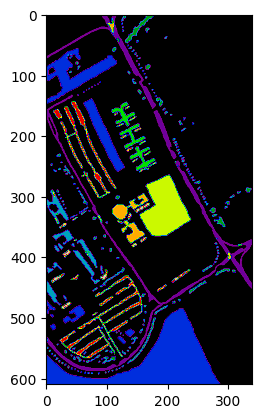

In [31]:

plt.imshow(gt_2, cmap='nipy_spectral')
plt.show()

In [32]:
gt_3= loadmat('/content/drive/MyDrive/dml/Pavia-veriseti/PaviaU_gt.mat')['paviaU_gt']

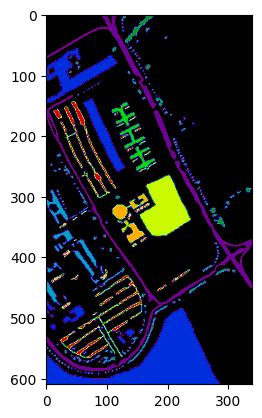

In [33]:
plt.imshow(gt_3,cmap='nipy_spectral')
plt.show()